# Model recovery attack: `news-popularity`

In [1]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import mra
from mra import *

In [2]:
def make_dataset(X, Y, f):
    x = tf.data.Dataset.from_tensor_slices(X)
    y = tf.data.Dataset.from_tensor_slices(Y)
    x = x.map(f)
    xy = tf.data.Dataset.zip((x, y))
    xy = xy.shuffle(10000)
    return xy

df = pd.read_csv('../datasets/news-popularity.csv').sample(frac=1)
df = df.drop(columns=["url"])
xy = df.to_numpy()
x = xy[:,0:-1]
y = xy[:,-1].reshape((len(x), 1))
# Normalize by feature to [0,1]
min_values = pd.DataFrame(x).describe().transpose()['min'].to_numpy()
max_values = pd.DataFrame(x).describe().transpose()['max'].to_numpy()
x = (x-min_values)/(max_values-min_values)
y = (y-min(y))/(max(y) - min(y))
train_ds = make_dataset(x, y, lambda t: t)

mra = mra(train_ds)

2022-02-10 11:05:34.672930: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-10 11:05:38.745035: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22336 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:3b:00.0, compute capability: 8.6
2022-02-10 11:05:38.745799: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 3178 MB memory:  -> device: 1, name: NVIDIA RTX A5000, pci bus id: 0000:5e:00.0, compute capability: 8.6
2022-02-10 11:05:38.746362: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:

In [3]:
def make_f(input_shape):
    xin = tf.keras.layers.Input(input_shape)
    x = tf.keras.layers.BatchNormalization()(xin)
    x = tf.keras.layers.Dense(128, activation="relu")(x)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    output = tf.keras.layers.Dense(512, activation="relu")(x)
    return tf.keras.Model(xin, output)

def make_g(input_shape):
    xin = tf.keras.layers.Input(input_shape)
    x = tf.keras.layers.Dense(512, activation="relu")(xin)
    x = tf.keras.layers.Dropout(0.5)(x)
    output = tf.keras.layers.Dense(1)(x)
    return tf.keras.Model(xin, output)

In [12]:
log_train = mra.train(
    make_f,
    make_g,
    loss_fn=tf.keras.losses.MeanSquaredError(),
    batch_size=32,
    epoch=1,
    lr=0.001,
    verbose=True, log_every=100)

Iteration 0001: Training loss: 0.1296
Iteration 0101: Training loss: 0.0009
Iteration 0201: Training loss: 0.0004
Iteration 0301: Training loss: 0.0001
Iteration 0401: Training loss: 0.0001
Iteration 0501: Training loss: 0.0000
Iteration 0601: Training loss: 0.0000
Iteration 0701: Training loss: 0.0000
Iteration 0801: Training loss: 0.0001
Iteration 0901: Training loss: 0.0000
Iteration 1001: Training loss: 0.0000
Iteration 1101: Training loss: 0.0000
Iteration 1201: Training loss: 0.0001


In [5]:
def make_generator(input_shape):
    xin = tf.keras.layers.Input(input_shape)
    act = "relu"
    x = tf.keras.layers.Dense(1024, activation=act)(xin)
    x = tf.keras.layers.Dense(512, activation=act)(x)
    x = tf.keras.layers.Dense(256, activation=act)(xin)
    x = tf.keras.layers.Dense(128, activation=act)(x)
    x = tf.keras.layers.Dense(59, activation="sigmoid")(x)
    return tf.keras.Model(xin, x)

In [10]:
log_attack = mra.attack(
    attack_iter=1,
    make_generator=make_generator,
    input_noise=True,
    input_z=True,
    model_leak=True,
    lr_x=0.001,
    lr_f=0.0001,
    epoch=200,
    iter_x=50,
    iter_f=1,
    verbose=True, log_every=10)

Iteration 0001: RG-uniform: 0.2605, RG-normal: 0.2334, reconstruction validation: 0.0499
Iteration 0011: RG-uniform: 0.2485, RG-normal: 0.2446, reconstruction validation: 0.0314
Iteration 0021: RG-uniform: 0.2664, RG-normal: 0.2491, reconstruction validation: 0.0331
Iteration 0031: RG-uniform: 0.2660, RG-normal: 0.2429, reconstruction validation: 0.0377
Iteration 0041: RG-uniform: 0.2579, RG-normal: 0.2419, reconstruction validation: 0.0389
Iteration 0051: RG-uniform: 0.2612, RG-normal: 0.2340, reconstruction validation: 0.0434
Iteration 0061: RG-uniform: 0.2556, RG-normal: 0.2393, reconstruction validation: 0.0438
Iteration 0071: RG-uniform: 0.2476, RG-normal: 0.2451, reconstruction validation: 0.0472
Iteration 0081: RG-uniform: 0.2643, RG-normal: 0.2399, reconstruction validation: 0.0515
Iteration 0091: RG-uniform: 0.2578, RG-normal: 0.2358, reconstruction validation: 0.0491


In [15]:
np.savetxt('./log/news.csv', log_attack, delimiter=',')

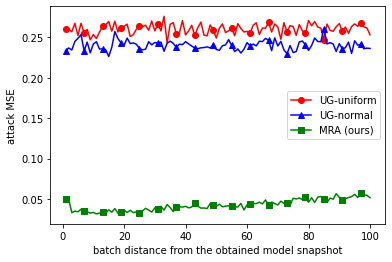

In [12]:
plt.ylabel('attack MSE')
plt.xlabel('batch distance from the obtained model snapshot')
ran = [i+1 for i in range(100)]
plt.plot(ran, log_attack[:,0], 'ro-', ran, log_attack[:,1], 'b^-', ran, log_attack[:,2], 'gs-', markevery=6)
plt.legend(['UG-uniform', 'UG-normal', 'MRA (ours)'], loc='center right')
plt.savefig("fig/news.pdf",bbox_inches='tight')